In [1]:
import math
import copy 
import tqdm
import time
import torch
import gpytorch
import pickle 
import itertools 
import warnings
import scipy
import scipy.sparse.linalg
from collections import defaultdict, OrderedDict

from math import comb
from numpy import matrix, asmatrix
from scipy.sparse.sputils import asmatrix

import random
import numpy as np
import fastmat as fm  # need 0.2a3 or later?

import matplotlib.gridspec as gridspec
warnings.filterwarnings("ignore")
from pylab import rcParams
from matplotlib import container
from matplotlib import pyplot as plt
from IPython.core.display import  HTML
from IPython.display import clear_output

import os, sys
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
os.environ['PRJ'] = "/Users/ymohit/sgkigp/"
sys.path.append(os.environ['PRJ'])

random.seed(1337)
np.random.seed(1337)

%matplotlib inline
%load_ext autoreload
%autoreload 2

/var/folders/gj/ns_zjdqx57b1mrqf3l8_rcd40000gp/T/ipykernel_98848/3898366358.py:16: DeprecationWarning: Please use `asmatrix` from the `scipy.sparse` namespace, the `scipy.sparse.sputils` namespace is deprecated.
  from scipy.sparse.sputils import asmatrix


In [2]:
from sgkigp.config import SgBasisType, InterpType
#from sgkigp.interp.sparse.basis import get_sg_comb_basis_1d
#from sgkigp.interp.sginterp import Interpolation
from sgkigp.interp.rginterp import Interpolation
from gpytorch.utils.interpolation import Interpolation as GpInterpolation
from gpytorch.utils.grid import create_grid

import sgkigp.tensorize as sparseInterpTensor
from sgkigp.interp.sparse.construct import G 

torch.Size([700, 2]) torch.Size([700, 2])


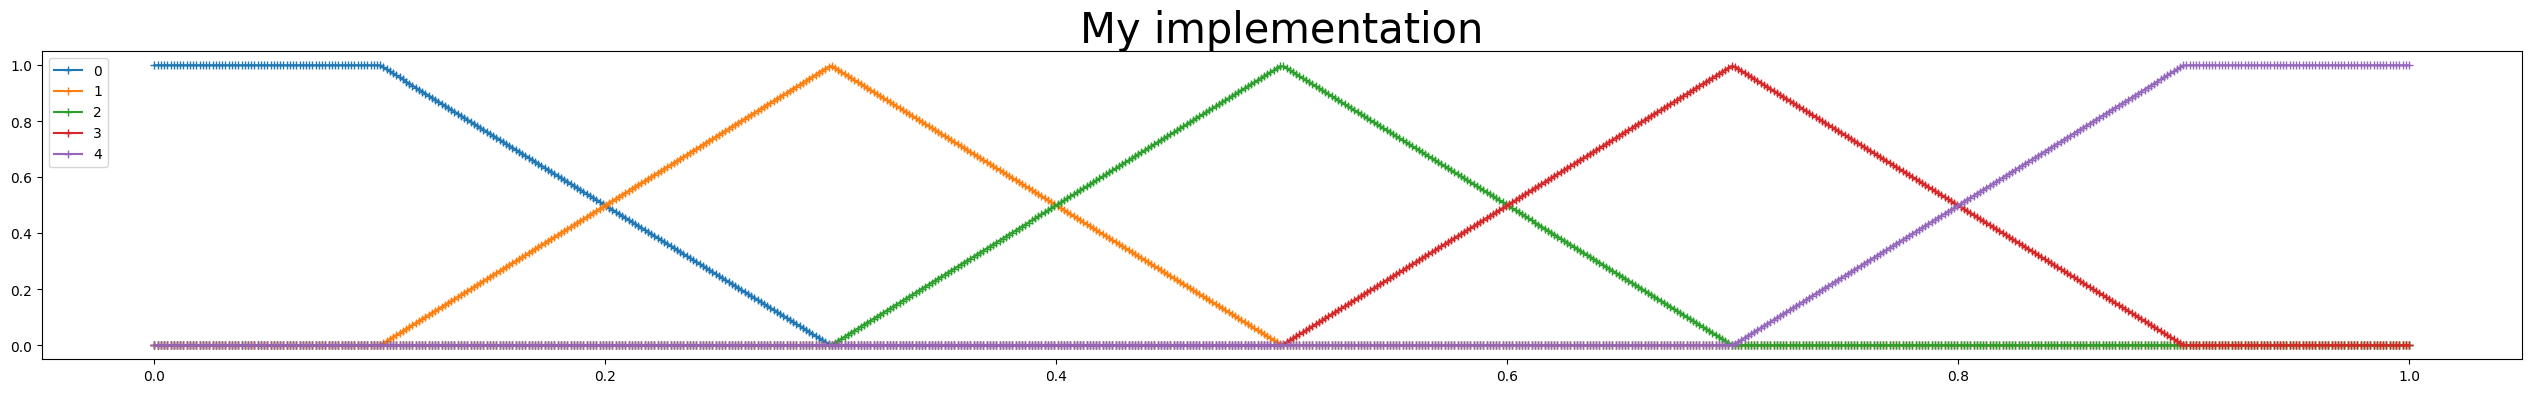

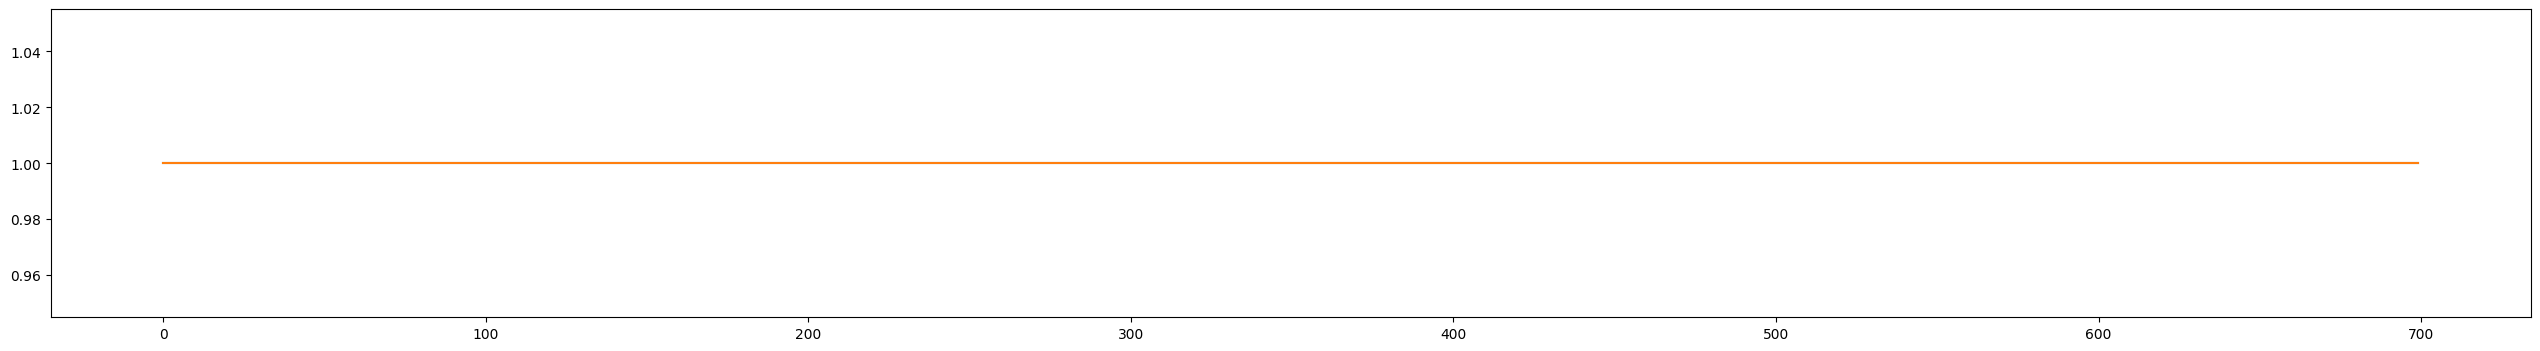

[tensor([0.0000, 0.2500, 0.5000, 0.7500, 1.0000])]
torch.Size([700, 4]) torch.Size([700, 4])


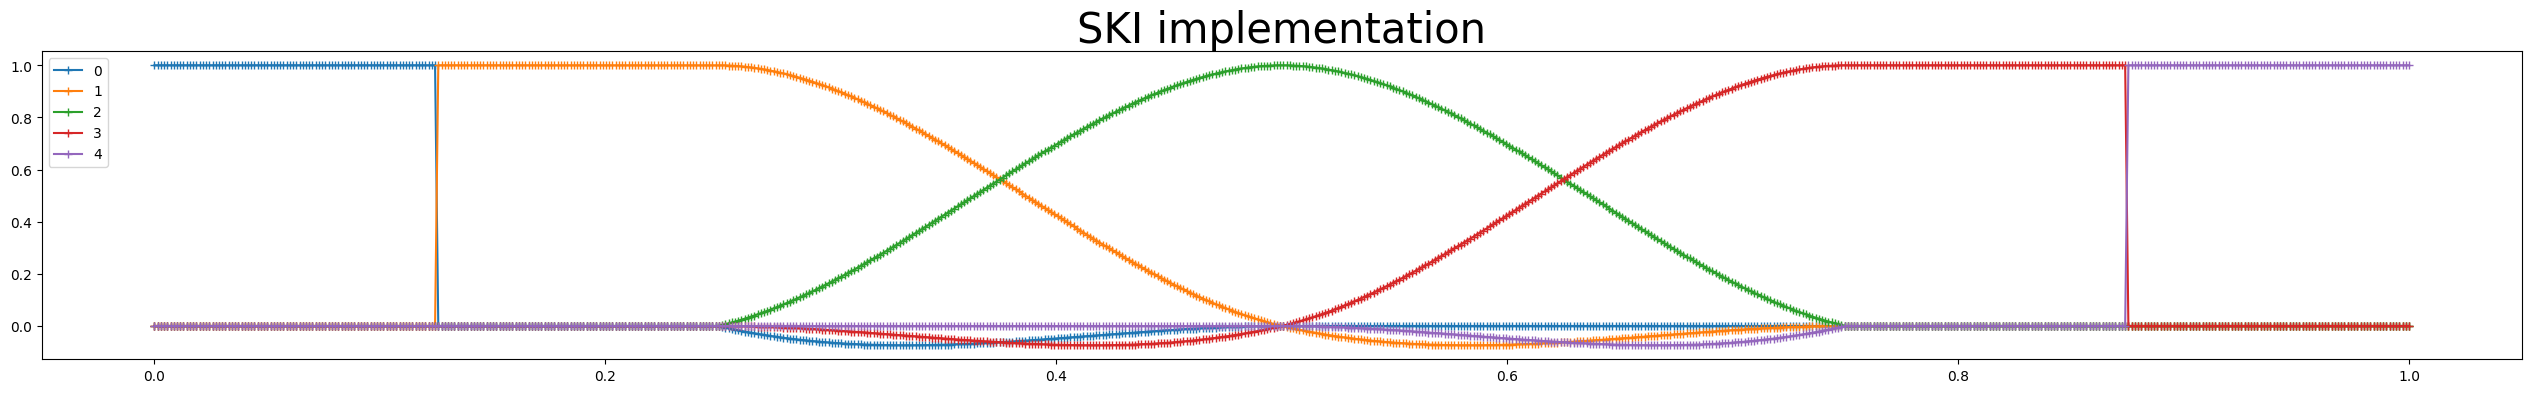

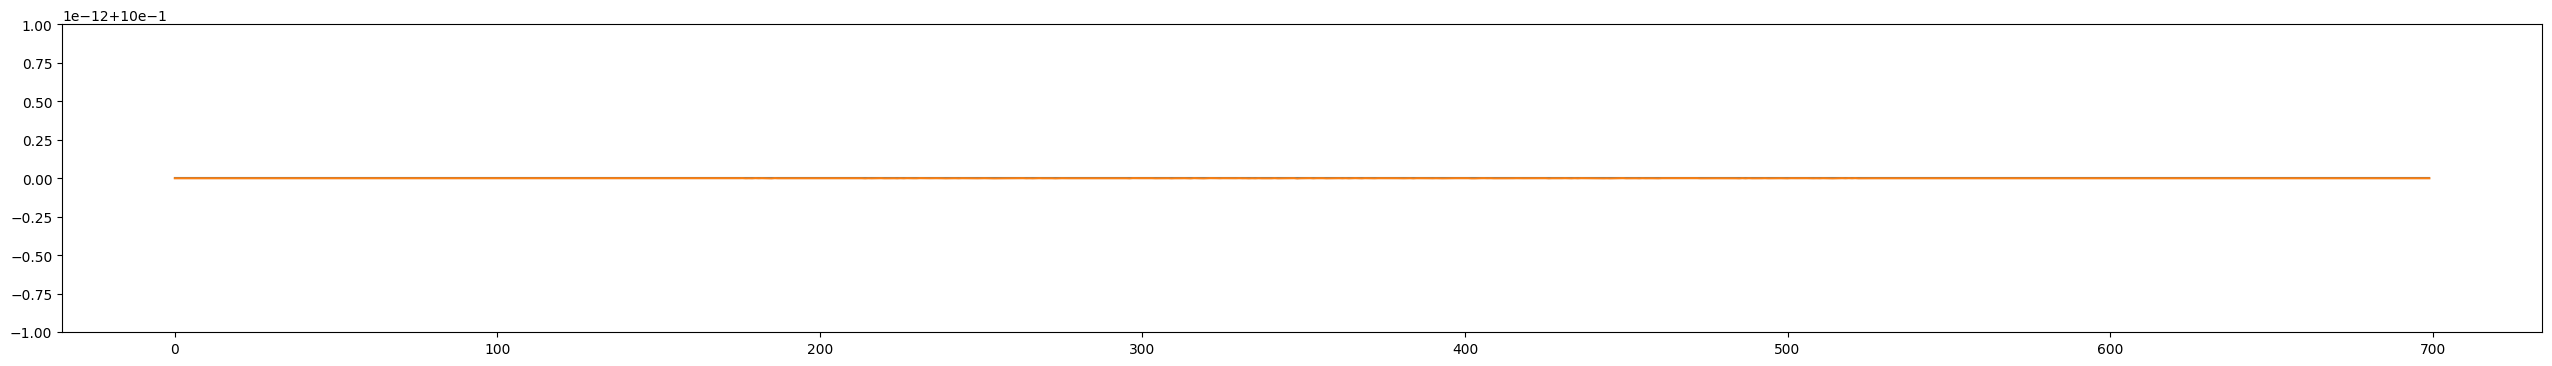

In [3]:
def get_interp_tensor(X, grid_size, grid_bounds, gpyt=False):
    inputs = X.reshape(-1, 1)
    n_data, n_dimensions = inputs.size(-2), inputs.size(-1)
    inputs = inputs.reshape(-1, n_dimensions)
    
    if gpyt:
        print(create_grid([grid_size], grid_bounds, extend=False))
        interp_indices, interp_values = GpInterpolation().interpolate(create_grid([grid_size], grid_bounds, extend=False), inputs)
    else:
#          interp_type=InterpType.CUBIC,
#                     x_grid=None, basis=SgBasisType.NAIVE
                
        interp_indices, interp_values = Interpolation().interpolate(grid_bounds, [grid_size], inputs, basis=SgBasisType.MODIFIED)
    
    print(interp_indices.shape, interp_values.shape)
    return sparseInterpTensor.unpack_and_sparse_tensor(interp_indices, interp_values, X.shape[0], grid_size).to_dense()

def plt_W(W, X, title):
    figsize = (32, 4)
    J = W.shape[1]
  
    fig, axs = plt.subplots(1, 1, figsize=figsize)  
    for j in range(J):                

        axs.plot(X, W[:, j], '+-', label=str(j))

    plt.legend(loc="upper left")
    plt.title(title, size=30)
    plt.show()
    fig, axs = plt.subplots(1, 1, figsize=figsize)  

    axs.plot([1]*len(W))
    axs.plot(torch.sum(W,axis=1))
    plt.show()

## functions for 1-D
umin = 0
umax = 1
ndim = 1

func = lambda x:  np.sin(1*np.pi*x)
vmin, vmax = -1, 1

ndimpoints = 700
epsilon = 0

grid_size = 5
spacing = 1.0/grid_size

X = np.linspace(0, 1, num=ndimpoints)
npoints = len(X)
X = torch.from_numpy(X)

#X = torch.tensor([0.0783, 0.4956])


grid_bounds = ((0.0, 1.0),)

W1 = get_interp_tensor(X, grid_size, grid_bounds, gpyt=False)
plt_W(W1, X,'My implementation')
# W11 = W1/torch.sum(W1, axis=1).reshape(-1, 1)
# plt_W(W11, X,'My implementation')

W2 = get_interp_tensor(X, grid_size, grid_bounds, gpyt=True)
plt_W(W2, X, 'SKI implementation')